In [3]:
#please mount your google drive if you are using it as your colab disk space.
from google.colab import drive
drive.mount('/content/gdrive' )

Mounted at /content/gdrive


In [14]:
#please designate a folder to read and write files for this code. Note that the lowest level folder "mini3_" should be the folder that stores our unzipped files
%cd '/content/gdrive/MyDrive/Colab Notebooks/mini3_'

/content/gdrive/MyDrive/Colab Notebooks/mini3_


In [15]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch
import cv2
from sklearn import metrics
import keras
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, Flatten, LeakyReLU, MaxPooling2D, AveragePooling2D, Dropout, Activation,ReLU
from tensorflow.keras.callbacks import TensorBoard
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow as tf
import csv


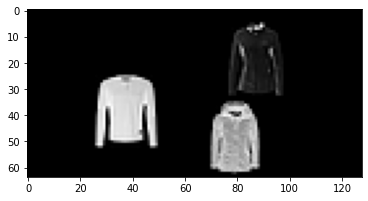

In [16]:
# Read a pickle file and disply its samples
data = pickle.load( open( './Train.pkl', 'rb' ),encoding='bytes')
targets = np.genfromtxt('./TrainLabels.csv', delimiter=',', skip_header=1)[:,1:]
test_data = pickle.load( open( './Test.pkl', 'rb' ),encoding='bytes')
plt.imshow(test_data[31,:,:],cmap='gray', vmin=0, vmax=256)

In [17]:
#data1 stores the training images
data1 = np.zeros((60000,64,128))
for i in range(data.shape[0]):
  _ = np.divide(data[i,:,:],255)
  data1[i,:,:] = np.divide(_-0.5,0.5)
#data_test stores the test set images
data_test = np.zeros((10000,64,128))
for i in range(test_data.shape[0]):
  _ = np.divide(test_data[i,:,:],255)
  data_test[i,:,:] = np.divide(_-0.5,0.5)

In [18]:
#this encode function turns the nine categories (5-13) to one hot-coded classes (e.g. [1 0 0 0 0 0 0 0 0] means the first class "5")
def encode(y):  
  value = np.zeros((len(y),9))
  for i in range(len(y)):
    value[i,int(y[i])-5]=1
  return value

In [21]:
#idx read the stored shuffled index for the training examples. A file named idx.csv is stored in the zipped file for this.
idx = np.genfromtxt('./idx.csv', dtype='int', delimiter=',')[:]

data2 = data1[idx,:,:]
targets2 = targets[idx]

index = idx.reshape(60000,1)
#index = idx
#with open('idx.csv','w') as f:
    #csv.writer(f).writerows(index)

<class 'numpy.int64'>


In [22]:
#reshaping the image for Keras
data2 = data2.reshape(-1,64,128,1)
data_test=data_test.reshape(-1,64,128,1)
#separating training set, validation set and pre-test set.
data_train = data2[:59000,:,:,:]
y_train = targets2[:59000]
y_train_ = y_train
y_train = encode(y_train)
data_val = data2[-5000:,:,:,:]
y_val = targets2[-5000:]
y_val_ = encode(y_val)
y_val = y_val.T
target2 = encode(targets2)

In [23]:
class convNet():
  def __init__(self, X, Y, LR, size, epoch):
    self.X = X #training examples
    self.Y = Y #targets
    self.LR = LR #learning rate for Leaky ReLU
    self.size = size #batch size
    self.epoch = epoch #number of epochs

  def buildConvnet(self, conv, channel, kernel, dense, neuron,l2_lam):
    model = Sequential()
    l2 = regularizers.l2(l2_lam) #defining the parameter of l2 regularization
    
    #ading convolutional layers
    for i in range(conv):
      if i == 0:
        #defining the first conv layer (2 convolution + max pooling + 20% dropout). The number of channel is 32.
        #first convolution with kernel size of (4,6), activation function of Leaky ReLU and no padding
        model.add(Conv2D(channel, kernel_size = (kernel, kernel+2),input_shape=self.X.shape[1:]))
        model.add(LeakyReLU(alpha=self.LR))
        #second convolution with kernel size of (4,4), activation function of Leaky ReLU and padding
        model.add(Conv2D(channel, kernel_size = (kernel, kernel), padding = 'same'))
        model.add(LeakyReLU(alpha=self.LR))
        #max pooling
        model.add(MaxPooling2D((2,4)))
        #dropout
        model.add(Dropout(0.2))     
      else:
        #building the second and third convolutional layers (2 convolution + max pooling + 20% dropout). The number of channel of the second and third layers are 64 and 128 respectively.
        channel = channel*2
        #first convolution with kernel size of (4,4), activation function of Leaky ReLU and padding
        model.add(Conv2D(channel, kernel_size = (kernel, kernel), padding = 'same'))
        model.add(LeakyReLU(alpha=self.LR))
        #second convolution with kernel size of (4,4), activation function of Leaky ReLU and padding
        model.add(Conv2D(channel, kernel_size = (kernel, kernel), padding = 'same'))
        model.add(LeakyReLU(alpha=self.LR))
        #max pooling
        model.add(MaxPooling2D((2,2)))
        #dropout
        model.add(Dropout(0.2))


    #this flatten layer transforms 8*8*128 to 1*8192
    model.add(Flatten())

    #adding dense (partially connected) layers. Each has l2 regularization. 30% dropout. ReLU as the activation function. The number of neurons of the three dense layers are 1350, 330 and 80.
    for i in range(dense):  
      model.add(Dense(neuron, kernel_regularizer=l2))
      model.add(Activation('relu'))
      model.add(Dropout(0.3))
      neuron = neuron/4

    #adding an output layer. The 9 neurons represent 9 classes. Softmax is used.
    model.add(Dense(9))
    model.add(Activation('softmax'))

    #Adam optimizer isused with a learning rate of 0.001 and a decay rate of 6*10E-7
    adam = Adam(lr=0.001, decay=6e-7)

    #The categorial class entropy is chosen as the loss function.
    model.compile(loss = 'categorical_crossentropy',optimizer = adam, metrics = ['accuracy'])

    #Here, the model starts to fit the training example with the designated batch size and epoch
    cnnf = model.fit(self.X, self.Y,
          batch_size=self.size,
          epochs=self.epoch,
          validation_split=0.02)
          #,callbacks=[tensorboard,model_checkpoint_callback])
    self.model = model
    return cnnf

  #predict the input data using the model built.   
  def predict(self,val):
    prediction = self.model.predict(val)
    return(prediction)

In [24]:
#learning rate
R = 0.01
#batch size
size = 1200
#number of epochs
epoch = 10
#number of conv layers
conv = [3]
#the number of channel for the first conv layer.
channel = [32]
#the size of kernel
kernel = [4]
#the number of dense layers
dense = [3]
#the number of neurons of the first dense layer
neuron = [1350]
#l2 regularization
l2 = [0.0006]
los = []
for i in conv:
  for j in channel:
    for k in kernel:
      for p in dense:
         for q in neuron:
            for o in l2:
              #starts to fit model
              cnn = convNet(data2, target2, LR, size, epoch)
              cnnf = cnn.buildConvnet(i,j,k,p,q,o)
              for z in range(5):
                if cnnf.history['val_accuracy'][-1] <0.0:
                  cnn = convNet(data2, target2, LR, size, epoch)
                  cnnf = cnn.buildConvnet(i,j,k,p,q,o)
            los.append(max(cnnf.history['val_accuracy']))


Epoch 1/10
49/49 [==============================] - 15s 303ms/step - loss: 2.7185 - accuracy: 0.1083 - val_loss: 2.2694 - val_accuracy: 0.1042
Epoch 2/10
49/49 [==============================] - 15s 304ms/step - loss: 2.2274 - accuracy: 0.1098 - val_loss: 2.2076 - val_accuracy: 0.1108
Epoch 3/10
49/49 [==============================] - 15s 304ms/step - loss: 2.2026 - accuracy: 0.1095 - val_loss: 2.1997 - val_accuracy: 0.1042
Epoch 4/10
49/49 [==============================] - 15s 304ms/step - loss: 2.1986 - accuracy: 0.1109 - val_loss: 2.1980 - val_accuracy: 0.1108
Epoch 5/10
49/49 [==============================] - 15s 304ms/step - loss: 2.1976 - accuracy: 0.1106 - val_loss: 2.1976 - val_accuracy: 0.0925
Epoch 6/10
49/49 [==============================] - 15s 304ms/step - loss: 2.1974 - accuracy: 0.1082 - val_loss: 2.1975 - val_accuracy: 0.0925
Epoch 7/10
49/49 [==============================] - 15s 304ms/step - loss: 2.1973 - accuracy: 0.1085 - val_loss: 2.1974 - val_accuracy: 0.0925

In [25]:
#for your convenience, we load the train model for you. The file is in the zipped package.
cnn.model.load_weights("cp/3-conv-32-channel-4-kernel-3-dense-1350-neuron-0.0006-reg")

In [28]:
prediction = cnn.predict(data_val)
pred_test = np.argmax(prediction, axis=1)
pred_test = pred+5

In [30]:
prediction_test = cnn.predict(data_test)
pred = np.argmax(prediction, axis=1)
pred = pred+5

In [29]:
accu = metrics.accuracy_score(y_val[0], pred)
print('The pre-test accuracy is:')
print(accu)

[1.3002258e-31 5.1550430e-16 7.0721229e-23 1.2328873e-09 4.8540628e-08
 2.6014769e-07 1.6907221e-07 9.9999952e-01 7.1993593e-09]
0.999


In [31]:
# Exporting the prediction of test dataset to csv file.
id = []
for i in np.arange(10000):
  id.append(i)

test_submission = np.array([id,pred_test.T]).T

with open('test_result.csv','w') as f:
    csv.writer(f).writerows(test_submission)